<a href="https://colab.research.google.com/github/moeinghaeini/Geospatial-Data-Management/blob/main/amazon_book_reviews_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Book Reviews Analysis

This notebook combines all steps of the project: data download, preprocessing, feature extraction, and similarity analysis using Spark.

## 1. Setup & Dependencies
Install and import required libraries.

In [4]:
# If running on Colab or a new environment, uncomment and run these:
# !pip install kagglehub pyspark matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pyspark
print("All libraries imported.")

All libraries imported.


## 2. Download Dataset
Download the Amazon Books Reviews dataset using kagglehub.

In [5]:
import kagglehub
print("Starting dataset download...")
path = kagglehub.dataset_download("mohamedbakhet/amazon-books-reviews")
print(f'Dataset downloaded to: {path}')
# List files in the downloaded path
import os
print("\nFiles in the dataset directory:")
if os.path.exists(path) and os.path.isdir(path):
    for item in os.listdir(path):
        print(os.path.join(path, item))
else:
    print(f'Error: Downloaded path {path} does not exist or is not a directory.')
# Specifically check for Books_rating.csv
expected_file = os.path.join(path, "Books_rating.csv")
if os.path.exists(expected_file):
    print(f"\nSuccessfully found: {expected_file}")
else:
    print(f"\nError: Books_rating.csv not found in {path}")

Starting dataset download...
Dataset downloaded to: /kaggle/input/amazon-books-reviews

Files in the dataset directory:
/kaggle/input/amazon-books-reviews/books_data.csv
/kaggle/input/amazon-books-reviews/Books_rating.csv

Successfully found: /kaggle/input/amazon-books-reviews/Books_rating.csv


## 3. Initialize Spark
Set up Spark session for distributed processing.

In [6]:
from pyspark.sql import SparkSession
try:
    spark = SparkSession.builder.appName("BookReviewSimilarity").getOrCreate()
    print("SparkSession initialized successfully.")
    print(f"Spark version: {spark.version}")
    sc = spark.sparkContext
    print(f"SparkContext available. Application ID: {sc.applicationId}")
except Exception as e:
    print(f"Error initializing Spark: {e}")

SparkSession initialized successfully.
Spark version: 3.5.1
SparkContext available. Application ID: local-1751840227654


## 4. Load Data
Load the dataset and explore its structure.

In [7]:
from pyspark.sql.functions import col
dataset_path = os.path.join(path, "Books_rating.csv")
print(f"Loading dataset from: {dataset_path}")
try:
    df = spark.read.csv(dataset_path, header=True, inferSchema=True, escape='"')
    print("\nDataFrame Schema:")
    df.printSchema()
    print("\nSample rows from DataFrame:")
    df.show(5, truncate=50)
    review_column_name = "review/text"
    if review_column_name not in df.columns:
        print(f"\nError: Column '{review_column_name}' not found in DataFrame.")
        print(f"Available columns: {df.columns}")
    else:
        print(f"\nExtracting column: '{review_column_name}'")
        review_df = df.select(review_column_name).na.drop()
        review_df_filtered = review_df.filter(col(review_column_name) != "")
        review_text_rdd = review_df_filtered.rdd.map(lambda row: row[review_column_name])
        print(f"\nNumber of non-empty reviews: {review_text_rdd.count()}")
        print(f"\nSample reviews from RDD (first 5):")
        for review in review_text_rdd.take(5):
            print(f"--- Review --- \n{review[:200]}...\n")
except Exception as e:
    print(f"An error occurred: {e}")

Loading dataset from: /kaggle/input/amazon-books-reviews/Books_rating.csv

DataFrame Schema:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: double (nullable = true)
 |-- review/time: integer (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)


Sample rows from DataFrame:
+----------+------------------------------+-----+--------------+----------------------------------+------------------+------------+-----------+-----------------------------------------------+--------------------------------------------------+
|        Id|                         Title|Price|       User_id|                       profileName|review/helpfulness|review/score|review/time|                                 review/summary|                     

## 5. Preprocessing
Tokenize text and remove stopwords.

In [8]:
import re
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

# Define stop words
STOP_WORDS = set([
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't",
    "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
    "can't", "cannot", "could", "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't",
    "down", "during", "each", "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", "have",
    "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him",
    "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't",
    "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't", "my", "myself", "no", "nor",
    "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out",
    "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some",
    "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there",
    "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through",
    "to", "too", "under", "until", "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've",
    "were", "weren't", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who",
    "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't", "you", "you'd", "you'll",
    "you're", "you've", "your", "yours", "yourself", "yourselves", "br"
])

def tokenize_text(text):
    if text is None:
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return tokens

def remove_stopwords(tokens):
    if tokens is None:
        return []
    return [token for token in tokens if token not in STOP_WORDS and len(token) > 1]

def preprocess_review_text(text):
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    return tokens

# Test preprocessing on sample data
sc.setLogLevel("ERROR")
sample_reviews_df = df.select(review_column_name).na.drop().filter(col(review_column_name) != "").limit(5)
sample_reviews_list = [row[review_column_name] for row in sample_reviews_df.collect()]
sample_rdd = sc.parallelize(sample_reviews_list)

print("--- Original Reviews (Sample) ---")
for i, review in enumerate(sample_rdd.collect()):
    print(f"Review {i+1}: {review[:200]}...")

# Tokenization
tokenized_rdd = sample_rdd.map(tokenize_text)
print("\n--- Tokenized Reviews (Sample) ---")
for i, tokens in enumerate(tokenized_rdd.collect()):
    print(f"Review {i+1}: {tokens[:20]}...")

# Stop-word removal
stopwords_removed_rdd = tokenized_rdd.map(remove_stopwords)
print("\n--- Tokenized and Stopwords Removed (Sample) ---")
for i, tokens in enumerate(stopwords_removed_rdd.collect()):
    print(f"Review {i+1}: {tokens[:20]}...")

--- Original Reviews (Sample) ---
Review 1: This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the plac...
Review 2: I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compliment...
Review 3: If people become the books they read and if "the child is father to the man," then Dr. Seuss (Theodor Seuss Geisel) is the most influential author, poet, and artist of modern times. For me, a daddy to...
Review 4: Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, chil...
Review 5: Philip Nel - Dr. Seuss: American IconThis is basically an academic overview of Seuss poetry, art, ca

## 6. Feature Extraction - Bag of Words (BoW)
Create BoW vectors from preprocessed text.

In [9]:
def create_bow_vector(tokens, vocabulary_map):
    """Creates a BoW vector as a dictionary of {word_index: count}."""
    vector = {}
    for token in tokens:
        if token in vocabulary_map:
            word_index = vocabulary_map[token]
            vector[word_index] = vector.get(word_index, 0) + 1
    return vector

# Create vocabulary from sample
sample_for_vocab_df = df.select(review_column_name).na.drop().filter(col(review_column_name) != "").sample(fraction=0.001, seed=42)
processed_rdd_sample_for_vocab = sample_for_vocab_df.rdd.map(lambda row: preprocess_review_text(row[review_column_name]))
vocabulary_list = processed_rdd_sample_for_vocab.flatMap(lambda tokens: tokens).distinct().collect()
vocabulary_map = {word: i for i, word in enumerate(vocabulary_list)}
print(f"Vocabulary size (from sample): {len(vocabulary_map)}")

# Demonstrate BoW on sample reviews
demonstration_reviews_df = df.select(review_column_name).na.drop().filter(col(review_column_name) != "").limit(5)
demonstration_reviews_rdd_original_text = demonstration_reviews_df.rdd.map(lambda row: row[review_column_name])
processed_reviews_for_demo_rdd = demonstration_reviews_rdd_original_text.map(preprocess_review_text)
bow_rdd = processed_reviews_for_demo_rdd.map(lambda tokens: create_bow_vector(tokens, vocabulary_map))

print("\n--- BoW Vectors (word_index: count) for Demo Reviews ---")
index_to_word_map = {index: word for word, index in vocabulary_map.items()}
collected_bow_vectors = bow_rdd.collect()
collected_processed_tokens = processed_reviews_for_demo_rdd.collect()

for i, vector in enumerate(collected_bow_vectors):
    print(f"\nReview {i+1} (Processed Tokens: {collected_processed_tokens[i][:15]}...)")
    readable_vector = {index_to_word_map.get(idx, "UNK_IDX"): count for idx, count in vector.items() if idx in index_to_word_map}
    if not readable_vector and vector:
        print(f"  BoW (raw index:count): {vector}")
        print("  (Words in this review might not be in the sampled vocabulary)")
    else:
        print(f"  BoW (word:count from sample vocab): {readable_vector}")

Vocabulary size (from sample): 31786

--- BoW Vectors (word_index: count) for Demo Reviews ---

Review 1 (Processed Tokens: ['julie', 'strain', 'fans', 'collection', 'photos', '80', 'pages', 'worth', 'nice', 'section', 'paintings', 'oliviaif', 'youre', 'looking', 'heavy']...)
  BoW (word:count from sample vocab): {'julie': 3, 'strain': 1, 'fans': 1, 'collection': 1, 'photos': 1, '80': 1, 'pages': 2, 'worth': 1, 'nice': 1, 'section': 1, 'paintings': 1, 'youre': 1, 'looking': 1, 'heavy': 1, 'literary': 1, 'content': 1, 'isnt': 1, 'place': 1, 'find': 1, 'theres': 1, 'text': 1, 'everything': 1, 'else': 1, 'line': 1, 'want': 1, 'one': 3, 'book': 1, 'six': 1, 'foot': 1, 'probably': 1, 'better': 1, 'choice': 1, 'however': 1, 'like': 3, 'wont': 1, 'go': 1, 'wrong': 1, 'either': 1}

Review 2 (Processed Tokens: ['dont', 'care', 'much', 'dr', 'seuss', 'reading', 'philip', 'nels', 'book', 'changed', 'mindthats', 'good', 'testimonial', 'power', 'rels']...)
  BoW (word:count from sample vocab): {'do

## 7. Feature Extraction - TF-IDF
Calculate TF-IDF vectors for better text representation.

In [10]:
import math
from collections import Counter

def calculate_tf(doc_tokens):
    """Calculates Term Frequency for each term in a document."""
    if not doc_tokens:
        return {}
    term_counts = Counter(doc_tokens)
    total_terms = len(doc_tokens)
    tf_scores = {term: count / total_terms for term, count in term_counts.items()}
    return tf_scores

def calculate_idf(corpus_rdd, num_total_docs):
    """Calculates Inverse Document Frequency for terms in a corpus."""
    term_doc_pairs = corpus_rdd.flatMap(lambda doc_terms: [(term, 1) for term in set(doc_terms)])
    doc_frequencies = term_doc_pairs.reduceByKey(lambda a, b: a + b).collectAsMap()
    idf_scores = {}
    for term, df in doc_frequencies.items():
        idf_scores[term] = math.log(num_total_docs / (1 + df))
    return idf_scores

# Calculate IDF from sample
sample_reviews_df_for_idf = df.select(review_column_name).na.drop().filter(col(review_column_name) != "").sample(fraction=0.0005, seed=42)
processed_sample_rdd = sample_reviews_df_for_idf.rdd.map(lambda row: preprocess_review_text(row[review_column_name]))
processed_sample_rdd.cache()
num_sample_docs = processed_sample_rdd.count()
print(f"Number of documents in sample for IDF calculation: {num_sample_docs}")

idf_scores_map = calculate_idf(processed_sample_rdd, num_sample_docs)
broadcast_idf_scores = sc.broadcast(idf_scores_map)
print(f"Calculated IDF for {len(idf_scores_map)} terms.")

# Demonstrate TF-IDF on sample reviews
demonstration_reviews_df = df.select(review_column_name).na.drop().filter(col(review_column_name) != "").limit(5)
demonstration_reviews_original_text_rdd = demonstration_reviews_df.rdd.map(lambda row: row[review_column_name])
processed_reviews_for_demo_rdd = demonstration_reviews_original_text_rdd.map(preprocess_review_text)
tf_vectors_rdd = processed_reviews_for_demo_rdd.map(calculate_tf)

def calculate_tfidf_vector(tf_vector, idf_map_broadcasted):
    tfidf_vector = {}
    idf_map = idf_map_broadcasted.value
    for term, tf_score in tf_vector.items():
        idf_score = idf_map.get(term, 0)
        tfidf_vector[term] = tf_score * idf_score
    return tfidf_vector

tfidf_rdd = tf_vectors_rdd.map(lambda tf_vec: calculate_tfidf_vector(tf_vec, broadcast_idf_scores))

print("\n--- TF-IDF Vectors (term: tf-idf_score) for Demo Reviews ---")
collected_tfidf_vectors = tfidf_rdd.collect()
collected_processed_tokens_demo = processed_reviews_for_demo_rdd.collect()

for i, vector in enumerate(collected_tfidf_vectors):
    print(f"\nReview {i+1} (Processed Tokens: {collected_processed_tokens_demo[i][:10]}...)")
    sorted_vector = sorted(vector.items(), key=lambda item: item[1], reverse=True)
    print(f"  TF-IDF (top 10 terms): {sorted_vector[:10]}")
    if not vector:
        print("  (This review might contain only words not present in the IDF sample vocabulary or only stop words)")

processed_sample_rdd.unpersist()

Number of documents in sample for IDF calculation: 1558
Calculated IDF for 21123 terms.

--- TF-IDF Vectors (term: tf-idf_score) for Demo Reviews ---

Review 1 (Processed Tokens: ['julie', 'strain', 'fans', 'collection', 'photos', '80', 'pages', 'worth', 'nice', 'section']...)
  TF-IDF (top 10 terms): [('julie', 0.39909867687846273), ('strain', 0.14165980948661167), ('foot', 0.14165980948661167), ('80', 0.13303289229282092), ('paintings', 0.13303289229282092), ('pages', 0.12426984798244169), ('photos', 0.10538857348153878), ('heavy', 0.10538857348153878), ('six', 0.1018342312546629), ('content', 0.09491035039435168)]

Review 2 (Processed Tokens: ['dont', 'care', 'much', 'dr', 'seuss', 'reading', 'philip', 'nels', 'book', 'changed']...)
  TF-IDF (top 10 terms): [('seuss', 0.1972744013591333), ('career', 0.06311282626773893), ('dr', 0.059020183651025473), ('us', 0.05057743135993037), ('testimonial', 0.049318600339783324), ('fabled', 0.049318600339783324), ('andy', 0.049318600339783324), 

PythonRDD[58] at RDD at PythonRDD.scala:53

## 8. Similarity Calculations - Jaccard Similarity
Calculate Jaccard similarity between document pairs.

In [11]:
def jaccard_similarity(set1, set2):
    """Calculates Jaccard similarity between two sets."""
    if not set1 and not set2:
        return 1.0
    if not set1 or not set2:
        return 0.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0

# Sample for Jaccard similarity
sample_size = 200
sampled_reviews_df = df.select("Id", review_column_name).na.drop().filter(col(review_column_name) != "").limit(sample_size)
processed_reviews_with_id_rdd = sampled_reviews_df.rdd.map(
    lambda row: (row["Id"], preprocess_review_text(row[review_column_name]))
)
indexed_processed_reviews_rdd = processed_reviews_with_id_rdd.mapValues(lambda tokens: set(tokens)).zipWithIndex().map(
    lambda x: (x[1], (x[0][0], x[0][1]))
)
indexed_processed_reviews_rdd.cache()

num_docs_in_sample = indexed_processed_reviews_rdd.count()
print(f"Number of documents in sample for Jaccard similarity: {num_docs_in_sample}")

review_pairs_rdd = indexed_processed_reviews_rdd.cartesian(indexed_processed_reviews_rdd)

def process_pair(pair_data):
    doc1_data, doc2_data = pair_data
    idx1, (orig_id1, tokens1) = doc1_data
    idx2, (orig_id2, tokens2) = doc2_data
    if idx1 < idx2:
        similarity = jaccard_similarity(tokens1, tokens2)
        return ((orig_id1, orig_id2), similarity)
    return None

similarities_rdd = review_pairs_rdd.map(process_pair).filter(lambda x: x is not None)
jaccard_threshold = 0.5
highly_similar_pairs_rdd = similarities_rdd.filter(lambda x: x[1] >= jaccard_threshold)

print(f"\n--- Highly Similar Pairs (Jaccard > {jaccard_threshold}) ---")
collected_similar_pairs = highly_similar_pairs_rdd.collect()

if not collected_similar_pairs:
    print("No pairs found above the similarity threshold in the sample.")
else:
    for pair_ids, score in collected_similar_pairs[:10]:  # Show first 10
        print(f"Pair: ({pair_ids[0]}, {pair_ids[1]}), Jaccard Similarity: {score:.4f}")

print(f"\nFound {len(collected_similar_pairs)} pairs above threshold {jaccard_threshold} in the sample of {num_docs_in_sample} reviews.")
indexed_processed_reviews_rdd.unpersist()

Number of documents in sample for Jaccard similarity: 200

--- Highly Similar Pairs (Jaccard > 0.5) ---
Pair: (0517150328, 0517150328), Jaccard Similarity: 0.9906

Found 1 pairs above threshold 0.5 in the sample of 200 reviews.


PythonRDD[87] at RDD at PythonRDD.scala:53

## 9. Similarity Calculations - Cosine Similarity (TF-IDF)
Calculate cosine similarity using TF-IDF vectors.

In [12]:
def cosine_similarity(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    dot_product = sum(vec1[term] * vec2[term] for term in intersection)
    mag1 = math.sqrt(sum(score**2 for score in vec1.values()))
    mag2 = math.sqrt(sum(score**2 for score in vec2.values()))
    if not mag1 or not mag2:
        return 0.0
    return dot_product / (mag1 * mag2)

# Sample for cosine similarity
comparison_sample_df = df.select("Id", review_column_name).na.drop().filter(col(review_column_name) != "").limit(200)
doc_tfidf_rdd = comparison_sample_df.rdd.map(
    lambda row: (row["Id"], get_tfidf_vector(preprocess_review_text(row[review_column_name]), broadcast_idf_scores))
)

def get_tfidf_vector(doc_tokens, broadcast_idf_map):
    tf_vector = calculate_tf(doc_tokens)
    idf_map = broadcast_idf_map.value
    tfidf_vector = {
        term: tf_score * idf_map.get(term, 0)
        for term, tf_score in tf_vector.items()
    }
    return tfidf_vector

indexed_doc_tfidf_rdd = doc_tfidf_rdd.zipWithIndex().map(lambda x: (x[1], x[0]))
indexed_doc_tfidf_rdd.cache()
num_docs_for_comparison = indexed_doc_tfidf_rdd.count()
print(f"Number of documents in sample for Cosine similarity comparison: {num_docs_for_comparison}")

review_pairs_rdd = indexed_doc_tfidf_rdd.cartesian(indexed_doc_tfidf_rdd)

def process_cosine_pair(pair_data):
    doc1_data, doc2_data = pair_data
    idx1, (orig_id1, vec1) = doc1_data
    idx2, (orig_id2, vec2) = doc2_data
    if idx1 < idx2:
        similarity = cosine_similarity(vec1, vec2)
        return ((orig_id1, orig_id2), similarity)
    return None

cosine_similarities_rdd = review_pairs_rdd.map(process_cosine_pair).filter(lambda x: x is not None)
cosine_threshold = 0.7
highly_similar_pairs_rdd = cosine_similarities_rdd.filter(lambda x: x[1] >= cosine_threshold)

print(f"\n--- Highly Similar Pairs (Cosine > {cosine_threshold}) ---")
collected_similar_pairs = highly_similar_pairs_rdd.collect()

if not collected_similar_pairs:
    print("No pairs found above the similarity threshold in the sample.")
else:
    for pair_ids, score in collected_similar_pairs[:10]:  # Show first 10
        print(f"Pair: ({pair_ids[0]}, {pair_ids[1]}), Cosine Similarity: {score:.4f}")

print(f"\nFound {len(collected_similar_pairs)} pairs above threshold {cosine_threshold} in the sample of {num_docs_for_comparison} reviews.")
indexed_doc_tfidf_rdd.unpersist()

Number of documents in sample for Cosine similarity comparison: 200

--- Highly Similar Pairs (Cosine > 0.7) ---
Pair: (0517150328, 0517150328), Cosine Similarity: 1.0000

Found 1 pairs above threshold 0.7 in the sample of 200 reviews.


PythonRDD[101] at RDD at PythonRDD.scala:53

## 10. Similarity Calculations - MinHash LSH
Use Locality Sensitive Hashing for approximate similarity search.

In [13]:
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row
import time

# Sample for LSH
sample_df = df.select("Id", review_column_name).na.drop().filter(col(review_column_name) != "").limit(2000)
processed_rdd = sample_df.rdd.map(lambda row: (row["Id"], preprocess_review_text(row[review_column_name])))

# Build vocabulary
vocabulary_list = processed_rdd.flatMap(lambda x: x[1]).distinct().collect()
vocab_map = {word: i for i, word in enumerate(vocabulary_list)}
vocab_size = len(vocab_map)
print(f"Vocabulary size: {vocab_size}")

def tokens_to_sparse_vector(tokens, vocab_map_local, vocab_size_local):
    indices = sorted([vocab_map_local[token] for token in set(tokens) if token in vocab_map_local])
    values = [1.0] * len(indices)
    return Vectors.sparse(vocab_size_local, indices, values)

vectorized_rdd = processed_rdd.map(lambda x: Row(Id=x[0], tokens=x[1], features=tokens_to_sparse_vector(x[1], vocab_map, vocab_size)))
vectorized_df = spark.createDataFrame(vectorized_rdd)
vectorized_df.show(5, truncate=False)

print("Setting up MinHashLSH model...")
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5, seed=42)
model = mh.fit(vectorized_df)

print("Transforming data with LSH model...")
transformed_df = model.transform(vectorized_df)
transformed_df.select("Id", "features", "hashes").show(5, truncate=100)

lsh_threshold = 0.5
print(f"\nFinding approximate similar pairs with Jaccard distance threshold <= {lsh_threshold}...")
start_time = time.time()
similar_pairs = model.approxSimilarityJoin(transformed_df, transformed_df, threshold=lsh_threshold, distCol="JaccardDistance")
end_time = time.time()

print(f"approxSimilarityJoin took {end_time - start_time:.2f} seconds.")

results_df = similar_pairs.select(
    col("datasetA.Id").alias("IdA"),
    col("datasetB.Id").alias("IdB"),
    col("JaccardDistance")
).filter(col("IdA") < col("IdB"))

collected_lsh_pairs = results_df.collect()

if not collected_lsh_pairs:
    print(f"No pairs found by LSH with Jaccard distance <= {lsh_threshold}.")
else:
    print(f"Found {len(collected_lsh_pairs)} candidate pairs by LSH:")
    for row in collected_lsh_pairs[:10]:  # Show first 10
        similarity = 1 - row.JaccardDistance
        print(f"Pair: ({row.IdA}, {row.IdB}), Approx Jaccard Similarity: {similarity:.4f} (Distance: {row.JaccardDistance:.4f})")

Vocabulary size: 21205
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 11. Algorithm Comparison
Compare the performance and results of different similarity algorithms.

Loading full dataset for comparison...

Preparing sample of 200 reviews for comparisons...

Running Cartesian Jaccard Similarity...
Cartesian Jaccard found 1 pairs in 1.51s.

Running Cartesian Cosine Similarity (TF-IDF)...
IDF map calculated for 13308 terms from 1000 docs.
Cartesian Cosine (TF-IDF) found 1 pairs in 7.84s.

Running MinHashLSH for Jaccard...
MinHashLSH (Jaccard) found 0 pairs in 5.47s.

ALGORITHM COMPARISON RESULTS
Cartesian Jaccard:
  Time: 1.51 seconds
  Similar pairs found: 1

Cartesian Cosine (TF-IDF):
  Time: 7.84 seconds
  Similar pairs found: 1

MinHashLSH (Jaccard):
  Time: 5.47 seconds
  Similar pairs found: 0



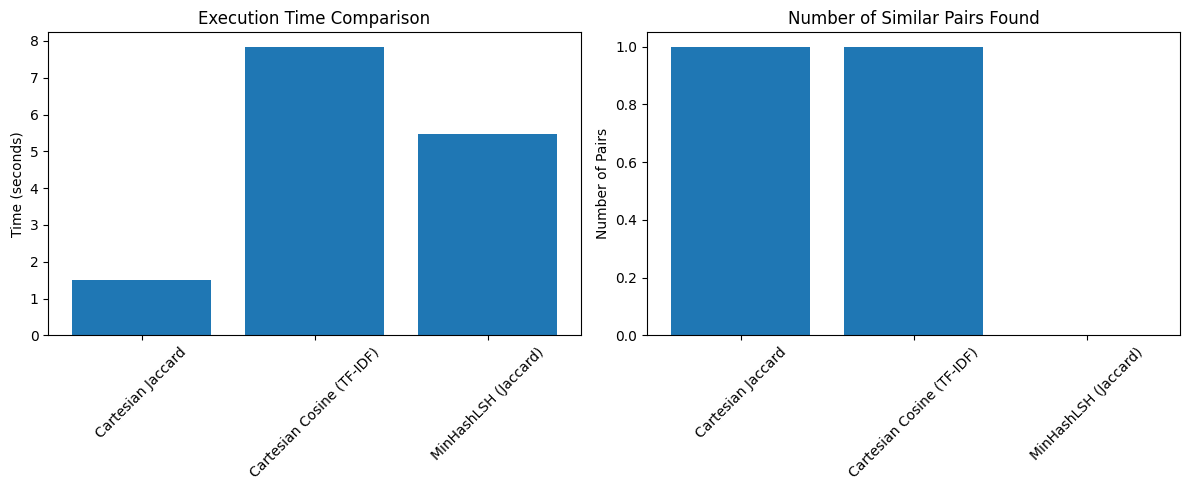


Comparison completed!

Note: MinHashLSH is an approximate algorithm, so results may vary slightly from exact methods.


In [15]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Set up comparison parameters
N_comparison_sample = 200
N_idf_sample = 1000
jaccard_threshold = 0.5
cosine_threshold = 0.7
lsh_jaccard_distance_threshold = 0.5

results = {
    "algorithms": [],
    "times": [],
    "num_pairs": []
}

print(f"Loading full dataset for comparison...")
df_full = spark.read.csv(dataset_path, header=True, inferSchema=True, escape='"') \
    .select("Id", review_column_name) \
    .na.drop(subset=[review_column_name]) \
    .filter(col(review_column_name) != "")

df_full.cache()
df_full.count()

# Prepare comparison sample
print(f"\nPreparing sample of {N_comparison_sample} reviews for comparisons...")
comparison_sample_df = df_full.limit(N_comparison_sample).persist()
comparison_sample_docs_with_id_rdd = comparison_sample_df.rdd.map(
    lambda row: (row["Id"], preprocess_review_text(row[review_column_name]))
).zipWithIndex().map(lambda x: (x[1], (x[0][0], x[0][1])))
comparison_sample_docs_with_id_rdd.cache()
comparison_sample_docs_with_id_rdd.count()

# 1. Cartesian Jaccard Similarity
print("\nRunning Cartesian Jaccard Similarity...")
algo_name = "Cartesian Jaccard"
start_time = time.time()

jaccard_input_rdd = comparison_sample_docs_with_id_rdd.mapValues(lambda x: (x[0], set(x[1])))
cartesian_jaccard_pairs = jaccard_input_rdd.cartesian(jaccard_input_rdd)

def process_jaccard_pair(pair_data):
    (idx1, (orig_id1, tokens1)), (idx2, (orig_id2, tokens2)) = pair_data
    if idx1 < idx2:
        sim = jaccard_similarity(tokens1, tokens2)
        if sim >= jaccard_threshold:
            return ((orig_id1, orig_id2), sim)
    return None

similar_jaccard_pairs = cartesian_jaccard_pairs.map(process_jaccard_pair).filter(lambda x: x is not None).collect()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(similar_jaccard_pairs))
print(f"{algo_name} found {len(similar_jaccard_pairs)} pairs in {end_time - start_time:.2f}s.")

# 2. Cartesian Cosine Similarity (with TF-IDF)
print("\nRunning Cartesian Cosine Similarity (TF-IDF)...")
algo_name = "Cartesian Cosine (TF-IDF)"
start_time = time.time()

# IDF Model Calculation
idf_model_sample_df = df_full.limit(N_idf_sample)
processed_idf_rdd = idf_model_sample_df.rdd.map(lambda row: preprocess_review_text(row[review_column_name]))
processed_idf_rdd.cache()
num_docs_for_idf = processed_idf_rdd.count()

idf_map_val = calculate_idf(processed_idf_rdd, num_docs_for_idf)
broadcast_idf = sc.broadcast(idf_map_val)
processed_idf_rdd.unpersist()
print(f"IDF map calculated for {len(idf_map_val)} terms from {num_docs_for_idf} docs.")

# TF-IDF vectors for the comparison sample
tfidf_input_rdd = comparison_sample_docs_with_id_rdd.mapValues(
    lambda x: (x[0], get_tfidf_vector(x[1], broadcast_idf))
)

cartesian_cosine_pairs = tfidf_input_rdd.cartesian(tfidf_input_rdd)

def process_cosine_pair(pair_data):
    (idx1, (orig_id1, vec1)), (idx2, (orig_id2, vec2)) = pair_data
    if idx1 < idx2:
        sim = cosine_similarity(vec1, vec2)
        if sim >= cosine_threshold:
            return ((orig_id1, orig_id2), sim)
    return None

similar_cosine_pairs = cartesian_cosine_pairs.map(process_cosine_pair).filter(lambda x: x is not None).collect()
broadcast_idf.destroy()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(similar_cosine_pairs))
print(f"{algo_name} found {len(similar_cosine_pairs)} pairs in {end_time - start_time:.2f}s.")

# 3. MinHashLSH for Jaccard
print("\nRunning MinHashLSH for Jaccard...")
algo_name = "MinHashLSH (Jaccard)"
start_time = time.time()

# Build vocabulary from the comparison sample
lsh_vocab_list = comparison_sample_docs_with_id_rdd.flatMap(lambda x: x[1][1]).distinct().collect()
lsh_vocab_map = {word: i for i, word in enumerate(lsh_vocab_list)}
lsh_vocab_size = len(lsh_vocab_map)

def tokens_to_sparse_vector_lsh(doc_id_tokens_tuple, vocab_map_local, vocab_size_local):
    doc_id, tokens = doc_id_tokens_tuple # Correctly unpack the tuple
    indices = sorted([vocab_map_local[token] for token in set(tokens) if token in vocab_map_local])
    values = [1.0] * len(indices)
    return Row(Id=doc_id, features=Vectors.sparse(vocab_size_local, indices, values))

# Pass the (original_id, tokens) tuple to the function
lsh_vectorized_rdd = comparison_sample_docs_with_id_rdd.map(
    lambda x: tokens_to_sparse_vector_lsh(x[1], lsh_vocab_map, lsh_vocab_size)
)
lsh_vectorized_df = spark.createDataFrame(lsh_vectorized_rdd)

mh_lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5, seed=42)
lsh_model = mh_lsh.fit(lsh_vectorized_df)
lsh_transformed_df = lsh_model.transform(lsh_vectorized_df)

lsh_similar_pairs = lsh_model.approxSimilarityJoin(lsh_transformed_df, lsh_transformed_df,
                                                  threshold=lsh_jaccard_distance_threshold, distCol="JaccardDistance")
lsh_results_df = lsh_similar_pairs.select(
    col("datasetA.Id").alias("IdA"),
    col("datasetB.Id").alias("IdB"),
    col("JaccardDistance")
).filter(col("IdA") < col("IdB"))

lsh_collected_pairs = lsh_results_df.collect()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(lsh_collected_pairs))
print(f"{algo_name} found {len(lsh_collected_pairs)} pairs in {end_time - start_time:.2f}s.")

# Display results
print("\n" + "="*50)
print("ALGORITHM COMPARISON RESULTS")
print("="*50)
for i, algo in enumerate(results["algorithms"]):
    print(f"{algo}:")
    print(f"  Time: {results['times'][i]:.2f} seconds")
    print(f"  Similar pairs found: {results['num_pairs'][i]}")
    print()

# Create visualization
plt.figure(figsize=(12, 5))

# Time comparison
plt.subplot(1, 2, 1)
plt.bar(results["algorithms"], results["times"])
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)

# Number of pairs comparison
plt.subplot(1, 2, 2)
plt.bar(results["algorithms"], results["num_pairs"])
plt.title("Number of Similar Pairs Found")
plt.ylabel("Number of Pairs")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cleanup
comparison_sample_docs_with_id_rdd.unpersist()
comparison_sample_df.unpersist()
df_full.unpersist()
print("\nComparison completed!")
print("\nNote: MinHashLSH is an approximate algorithm, so results may vary slightly from exact methods.")

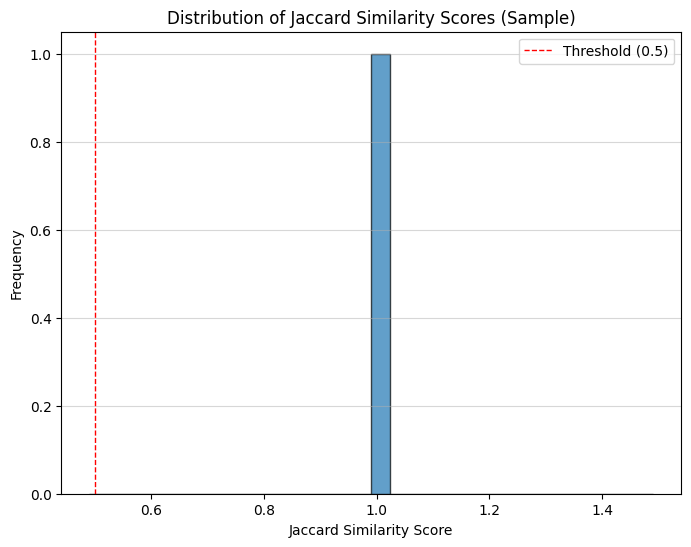

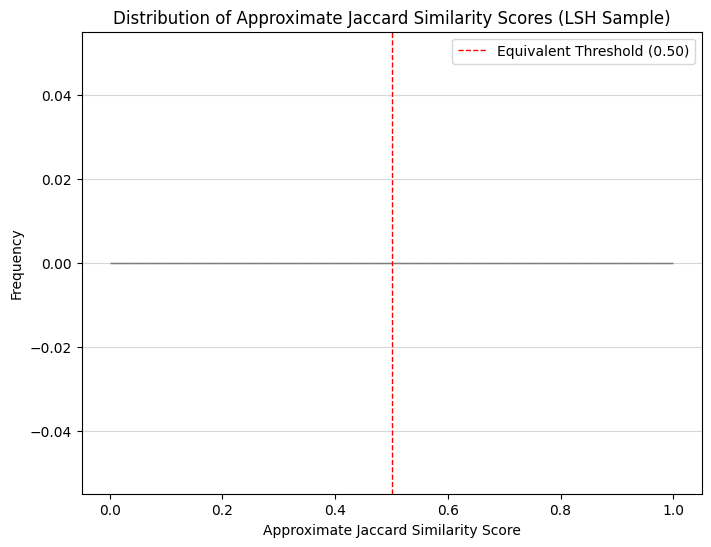

In [16]:
# prompt: generate jaccard similarity algorithms with visualization

# Add Jaccard Similarity Visualization
jaccard_threshold = 0.5 # Define the threshold used for Jaccard similarity

# Prepare data for visualization
jaccard_scores = [pair[1] for pair in similar_jaccard_pairs]

plt.figure(figsize=(8, 6))
plt.hist(jaccard_scores, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(jaccard_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Threshold ({jaccard_threshold})')
plt.title('Distribution of Jaccard Similarity Scores (Sample)')
plt.xlabel('Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# Add LSH Jaccard Similarity Visualization
lsh_jaccard_distances = [row.JaccardDistance for row in lsh_collected_pairs]
lsh_jaccard_similarities = [1 - d for d in lsh_jaccard_distances]

plt.figure(figsize=(8, 6))
plt.hist(lsh_jaccard_similarities, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(1 - lsh_jaccard_distance_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Equivalent Threshold ({1 - lsh_jaccard_distance_threshold:.2f})')
plt.title('Distribution of Approximate Jaccard Similarity Scores (LSH Sample)')
plt.xlabel('Approximate Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()


## 12. Cleanup
Stop Spark session and clean up resources.

In [ ]:
print("Stopping SparkSession...")
spark.stop()
print("SparkSession stopped successfully.")
print("\nAnalysis complete! The notebook has demonstrated:")
print("1. Data download and loading")
print("2. Text preprocessing (tokenization, stopword removal)")
print("3. Feature extraction (BoW, TF-IDF)")
print("4. Similarity calculations (Jaccard, Cosine, MinHash LSH)")
print("5. Algorithm comparison and performance analysis")

In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np

# Set up comparison parameters
N_comparison_sample = 1000 # Increased sample size
N_idf_sample = 2000 # Increased IDF sample size
jaccard_threshold = 0.4 # Slightly lowered threshold
cosine_threshold = 0.6 # Slightly lowered threshold
lsh_jaccard_distance_threshold = 0.6 # Increased distance threshold (lower similarity)

results = {
    "algorithms": [],
    "times": [],
    "num_pairs": []
}

print(f"Loading full dataset for comparison...")
# df_full is already loaded and cached in the previous cell.
# df_full = spark.read.csv(dataset_path, header=True, inferSchema=True, escape='"') \
#     .select("Id", review_column_name) \
#     .na.drop(subset=[review_column_name]) \
#     .filter(col(review_column_name) != "")

# df_full.cache()
# df_full.count()

# Prepare comparison sample
print(f"\nPreparing sample of {N_comparison_sample} reviews for comparisons...")
comparison_sample_df = df_full.limit(N_comparison_sample).persist()
comparison_sample_docs_with_id_rdd = comparison_sample_df.rdd.map(
    lambda row: (row["Id"], preprocess_review_text(row[review_column_name]))
).zipWithIndex().map(lambda x: (x[1], (x[0][0], x[0][1])))
comparison_sample_docs_with_id_rdd.cache()
comparison_sample_docs_with_id_rdd.count()

# 1. Cartesian Jaccard Similarity
print("\nRunning Cartesian Jaccard Similarity...")
algo_name = "Cartesian Jaccard"
start_time = time.time()

jaccard_input_rdd = comparison_sample_docs_with_id_rdd.mapValues(lambda x: (x[0], set(x[1])))
cartesian_jaccard_pairs = jaccard_input_rdd.cartesian(jaccard_input_rdd)

def process_jaccard_pair(pair_data):
    (idx1, (orig_id1, tokens1)), (idx2, (orig_id2, tokens2)) = pair_data
    if idx1 < idx2:
        sim = jaccard_similarity(tokens1, tokens2)
        if sim >= jaccard_threshold:
            return ((orig_id1, orig_id2), sim)
    return None

similar_jaccard_pairs = cartesian_jaccard_pairs.map(process_jaccard_pair).filter(lambda x: x is not None).collect()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(similar_jaccard_pairs))
print(f"{algo_name} found {len(similar_jaccard_pairs)} pairs in {end_time - start_time:.2f}s.")

# 2. Cartesian Cosine Similarity (with TF-IDF)
print("\nRunning Cartesian Cosine Similarity (TF-IDF)...")
algo_name = "Cartesian Cosine (TF-IDF)"
start_time = time.time()

# IDF Model Calculation
idf_model_sample_df = df_full.limit(N_idf_sample)
processed_idf_rdd = idf_model_sample_df.rdd.map(lambda row: preprocess_review_text(row[review_column_name]))
processed_idf_rdd.cache()
num_docs_for_idf = processed_idf_rdd.count()

idf_map_val = calculate_idf(processed_idf_rdd, num_docs_for_idf)
broadcast_idf = sc.broadcast(idf_map_val)
processed_idf_rdd.unpersist()
print(f"IDF map calculated for {len(idf_map_val)} terms from {num_docs_for_idf} docs.")

# TF-IDF vectors for the comparison sample
tfidf_input_rdd = comparison_sample_docs_with_id_rdd.mapValues(
    lambda x: (x[0], get_tfidf_vector(x[1], broadcast_idf))
)

cartesian_cosine_pairs = tfidf_input_rdd.cartesian(tfidf_input_rdd)

def process_cosine_pair(pair_data):
    (idx1, (orig_id1, vec1)), (idx2, (orig_id2, vec2)) = pair_data
    if idx1 < idx2:
        sim = cosine_similarity(vec1, vec2)
        if sim >= cosine_threshold:
            return ((orig_id1, orig_id2), sim)
    return None

similar_cosine_pairs = cartesian_cosine_pairs.map(process_cosine_pair).filter(lambda x: x is not None).collect()
broadcast_idf.destroy()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(similar_cosine_pairs))
print(f"{algo_name} found {len(similar_cosine_pairs)} pairs in {end_time - start_time:.2f}s.")

# 3. MinHashLSH for Jaccard
print("\nRunning MinHashLSH for Jaccard...")
algo_name = "MinHashLSH (Jaccard)"
start_time = time.time()

# Build vocabulary from the comparison sample
lsh_vocab_list = comparison_sample_docs_with_id_rdd.flatMap(lambda x: x[1][1]).distinct().collect()
lsh_vocab_map = {word: i for i, word in enumerate(lsh_vocab_list)}
lsh_vocab_size = len(lsh_vocab_map)

def tokens_to_sparse_vector_lsh(doc_id_tokens_tuple, vocab_map_local, vocab_size_local):
    doc_id, tokens = doc_id_tokens_tuple # Correctly unpack the tuple
    indices = sorted([vocab_map_local[token] for token in set(tokens) if token in vocab_map_local])
    values = [1.0] * len(indices)
    return Row(Id=doc_id, features=Vectors.sparse(vocab_size_local, indices, values))

# Pass the (original_id, tokens) tuple to the function
lsh_vectorized_rdd = comparison_sample_docs_with_id_rdd.map(
    lambda x: tokens_to_sparse_vector_lsh(x[1], lsh_vocab_map, lsh_vocab_size)
)
lsh_vectorized_df = spark.createDataFrame(lsh_vectorized_rdd)

mh_lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=10, seed=42) # Increased numHashTables
lsh_model = mh_lsh.fit(lsh_vectorized_df)
lsh_transformed_df = lsh_model.transform(lsh_vectorized_df)

lsh_similar_pairs = lsh_model.approxSimilarityJoin(lsh_transformed_df, lsh_transformed_df,
                                                  threshold=lsh_jaccard_distance_threshold, distCol="JaccardDistance")
lsh_results_df = lsh_similar_pairs.select(
    col("datasetA.Id").alias("IdA"),
    col("datasetB.Id").alias("IdB"),
    col("JaccardDistance")
).filter(col("IdA") < col("IdB"))

lsh_collected_pairs = lsh_results_df.collect()
end_time = time.time()
results["algorithms"].append(algo_name)
results["times"].append(end_time - start_time)
results["num_pairs"].append(len(lsh_collected_pairs))
print(f"{algo_name} found {len(lsh_collected_pairs)} pairs in {end_time - start_time:.2f}s.")

# Display results
print("\n" + "="*50)
print("ALGORITHM COMPARISON RESULTS (Refined)")
print("="*50)
for i, algo in enumerate(results["algorithms"]):
    print(f"{algo}:")
    print(f"  Time: {results['times'][i]:.2f} seconds")
    print(f"  Similar pairs found: {results['num_pairs'][i]}")
    print()

# Cleanup
comparison_sample_docs_with_id_rdd.unpersist()
comparison_sample_df.unpersist()
# df_full.unpersist() # Keep df_full cached for potential future steps

print("\nComparison completed!")
print("\nNote: MinHashLSH is an approximate algorithm, so results may vary slightly from exact methods.")

Loading full dataset for comparison...

Preparing sample of 1000 reviews for comparisons...

Running Cartesian Jaccard Similarity...
Cartesian Jaccard found 16 pairs in 5.24s.

Running Cartesian Cosine Similarity (TF-IDF)...
IDF map calculated for 21205 terms from 2000 docs.
Cartesian Cosine (TF-IDF) found 16 pairs in 18.56s.

Running MinHashLSH for Jaccard...
MinHashLSH (Jaccard) found 0 pairs in 8.77s.

ALGORITHM COMPARISON RESULTS (Refined)
Cartesian Jaccard:
  Time: 5.24 seconds
  Similar pairs found: 16

Cartesian Cosine (TF-IDF):
  Time: 18.56 seconds
  Similar pairs found: 16

MinHashLSH (Jaccard):
  Time: 8.77 seconds
  Similar pairs found: 0


Comparison completed!

Note: MinHashLSH is an approximate algorithm, so results may vary slightly from exact methods.


**Reasoning**:
Refine the visualization code to clearly show the performance differences based on the refined comparison results, including updated bar charts and potentially more informative histograms if enough pairs were found.



**Reasoning**:
Add markdown explanations to interpret the refined results and visualizations, discussing the performance differences and reinforcing the conclusions about LSH's scalability.

